In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from itertools import islice, cycle
from more_itertools import pairwise
from tqdm.auto import tqdm

In [7]:
ratings = pd.read_csv('/content/drive/MyDrive/test/VK/rating.csv', parse_dates=['timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [8]:
movies = pd.read_csv('/content/drive/MyDrive/test/VK/movie.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
# Достанем год выпуска фильма
movies['year'] = movies['title'].map(lambda x: x[x.find('(')+1:x.find(')')])

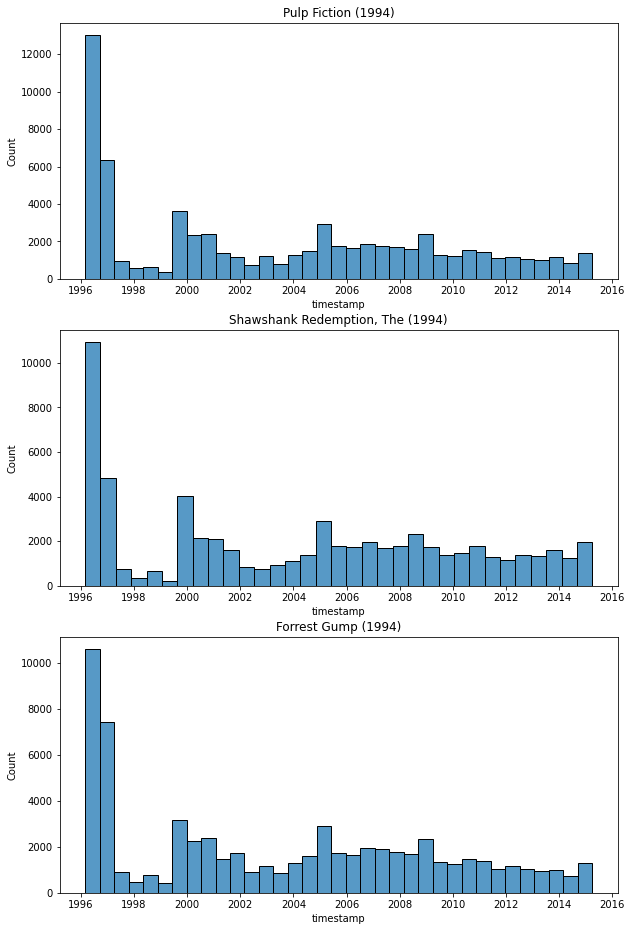

In [55]:
# Посмотрим, как менялась популярность 3 самых просматриваемых фильмов
popular_movies = ratings[ratings['movieId'].isin(ratings['movieId'].value_counts()[:3].index)]
popular_movies.head()

fig, axes = plt.subplots(3, figsize=(10, 16))

sns.histplot(popular_movies.query('movieId == 296')['timestamp'], ax=axes[0])
axes[0].set_title(list(movies.query('movieId == 296').title)[0])
sns.histplot(popular_movies.query('movieId == 318')['timestamp'], ax=axes[1])
axes[1].set_title(list(movies.query('movieId == 318').title)[0])
sns.histplot(popular_movies.query('movieId == 356')['timestamp'], ax=axes[2])
axes[2].set_title(list(movies.query('movieId == 356').title)[0])

plt.show()

In [11]:
# Оставим фильмы, которые просматривали больше 4 раз
movie_frec = ratings['movieId'].value_counts()
ratings = ratings[ratings['movieId'].isin(movie_frec[movie_frec >= 5].index)]

In [12]:
users_inv_mapping = dict(enumerate(ratings['userId'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}

In [13]:
items_inv_mapping = dict(enumerate(np.sort(ratings['movieId'].unique())))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
len(items_mapping)

18345

In [14]:
print(f"Количество пользователей: {ratings['userId'].nunique()}")
print(f"Количество фильмов: {ratings['movieId'].nunique()}")

Количество пользователей: 138493
Количество фильмов: 18345


In [15]:
max_date = ratings['timestamp'].max()
min_date = ratings['timestamp'].min()

print(f"min дата в ratings: {min_date}")
print(f"max дата в ratings: {max_date}")

min дата в ratings: 1995-01-09 11:46:44
max дата в ratings: 2015-03-31 06:40:02


In [16]:
# Делим датасет на тренировочную и тестовую часть
train = ratings[(ratings['timestamp'] < max_date - pd.Timedelta(days=7))]
test = ratings[(ratings['timestamp'] >= max_date - pd.Timedelta(days=7))]

# Будем предсказывать только на горячих пользователях
test = test[test['userId'].isin(train['userId'].unique())]

In [17]:
def get_coo_matrix(df, 
                   user_col='userId', 
                   item_col='movieId', 
                   weight_col='rating', 
                   users_mapping=users_mapping, 
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [18]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['userId', 'movieId']).join(df_pred.set_index(['userId', 'movieId']))
    test_recs = test_recs.sort_values(by=['userId', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='userId')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='userId').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('userId').nunique()
    k = top_N
    hit_k = f'hit@{k}'
    test_recs[hit_k] = test_recs['rank'] <= k
    result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
    result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='userId')['reciprocal_rank'].max().mean()
    return pd.Series(result)

# implicit ALS

In [21]:
!pip install implicit==0.4.4

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3413744 sha256=ac070e0da8ca4c5e27800f8ad86930baf87d2cd96b35cb619d3e88fb29494dd0
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
Successfully built implicit


In [22]:
from implicit.als import AlternatingLeastSquares

def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
    def _recs_mapper(user):
        userId = user_mapping[user]
        recs = model.recommend(userId, 
                               train_matrix, 
                               N=N, 
                               filter_already_liked_items=True)
        return [item_inv_mapping[item] for item, _ in recs]
    return _recs_mapper

## Обучение модели и получение списка рекомендаций

In [51]:
train_matrix[0].toarray()

array([[0. , 3.5, 0. , ..., 0. , 0. , 0. ]], dtype=float32)

In [77]:
top_N = 15

train_matrix = get_coo_matrix(train).tocsr()

als_model = AlternatingLeastSquares(factors=32, iterations=30, num_threads=4)
als_model.fit(train_matrix.T)

mapper = generate_implicit_recs_mapper(als_model, train_matrix, top_N, users_mapping, items_inv_mapping)

recs_als = pd.DataFrame({
    'userId': test['userId'].unique()
})
recs_als['movieId'] = recs_als['userId'].map(mapper)
recs_als = recs_als.explode('movieId')
recs_als['rank'] = recs_als.groupby('userId').cumcount() + 1
metrics_als = compute_metrics(test, recs_als, top_N)

In [87]:
recs_als

,userId,movieId,rank
0,96,82209,1
0,96,8800,2
0,96,59392,3
0,96,43897,4
0,96,68486,5
...,...,...,...
737,138186,59392,6
737,138186,118924,7
737,138186,92498,8
737,138186,83468,9


In [59]:
metrics_als

Precision@15    0.031165
Recall@15       0.049359
MAP@15          0.016692
MRR             0.088207
dtype: float64

# LightFM

In [32]:
!pip install lightfm 
from lightfm.data import Dataset
from lightfm import LightFM

     |████████████████████████████████| 310 kB 4.7 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705381 sha256=4332426b7ee99d07299f9ce4b73f09af29043d7b93618cd97c7960789534a9d8
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [33]:
dataset = Dataset()
dataset.fit(ratings['userId'].unique(), ratings['movieId'].unique())

In [34]:
# Получим список жанров
movies = movies[movies['movieId'].isin(ratings['movieId'].unique())]
genres = list(movies['genres'].str.split('|').explode().unique())
movies['features'] = movies['genres'].str.split('|')

dataset.fit_partial(item_features=genres)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [35]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}

In [36]:
# Построение матрицы взаимодействий вида: [(user_id1, item_id1, weight), (user_id2, item_id2, weight), ...]
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*train[['userId', 'movieId', 'rating']].values.T)
)

In [37]:
def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [38]:
# Построение матрицы фичей вида: (1, ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'])
movies = movies[movies['movieId'].isin(ratings['movieId'].unique())]

train_items_features = dataset.build_item_features(
    df_to_tuple_list_iterator(
        movies[['movieId', 'features']]
    )
)

## Обучение модели LightFM

In [39]:
lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 
    loss='warp', 
    max_sampled=5, 
    random_state=42
)

num_epochs = 20
for _ in tqdm(range(num_epochs), total=num_epochs):
    lfm_model.fit_partial(
        weights_matrix,
        item_features=train_items_features,
        num_threads=4
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [40]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [41]:
known_items = train.groupby('userId')['movieId'].apply(list).to_dict()
len(known_items)

all_cols = list(lightfm_mapping['items_mapping'].values())

In [43]:
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [45]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    item_features=train_items_features, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=4
)

recs_lightfm = pd.DataFrame({
    'userId': test['userId'].unique()
})
recs_lightfm['movieId'] = recs_lightfm['userId'].map(mapper)
recs_lightfm = recs_lightfm.explode('movieId')
recs_lightfm['rank'] = recs_lightfm.groupby('userId').cumcount() + 1
metrics_lightfm = compute_metrics(test, recs_lightfm, top_N)
metrics_lightfm

Precision@15    0.008762
Recall@15       0.009864
MAP@15          0.002242
MRR             0.018949
dtype: float64